# TODO:

- Transfer to torch.masked <- actually insanely cool, BUT does not work for weights AND does not work for grad rn :(((
- Maybe use model.state_dict() rather than .parameters()? 

# Lottery Ticket Hypothesis Result Reproduction

This notebook serves to reproduce the results of the section: **2 WINNING TICKETS IN FULLY-CONNECTED NETWORKS** of the original lottery ticket hypothesis paper: https://arxiv.org/abs/1803.03635 

This section includes:
* Iterative pruning
* Random reinitialization
* One-shot pruning

**TODO**: Section - 3 WINNING TICKETS IN CONVOLUTIONAL NEURAL NETWORKS:
* Finding Wining Tickets
* Random Reinitialization 
* Dropout

Each of those sections can be found below: #, along with the first "Setup" section which includes code used in all sections:

### Imports and GPU available

In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.masked import masked_tensor
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.manual_seed(491495711086) # manual seed set here, but also later on (just to be sure ^^)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(Markdown(f"**--Using {device}--**"))

**--Using cuda--**

# 2 WINNING TICKETS IN FULLY-CONNECTED NETWORKS

### Here are the different models in the original paper:

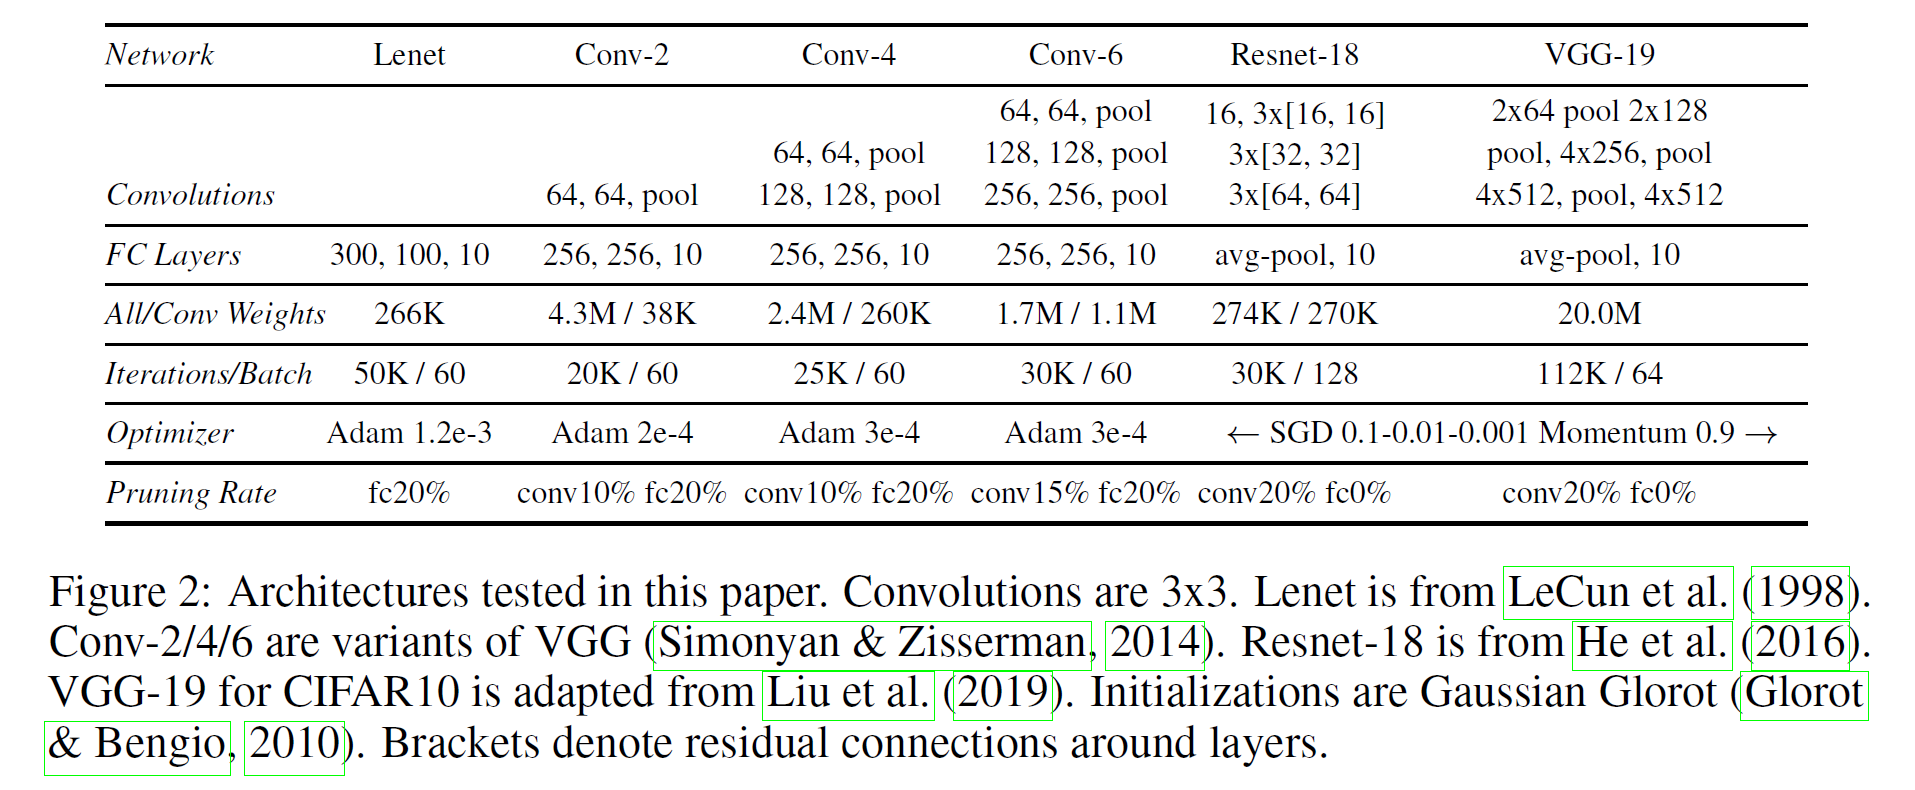


This section focuses on the first of the models above, the "Lenet300-100" architecture, which is based entirely on a fully-connected network from this paper https://ieeexplore.ieee.org/document/726791 explained in the section *6) Two-Hidden-Layer Fully Connected Multilayer NN* on page 2291. An important fact from the paper is the following: "Connections to outputs are pruned at half of the rate of the rest of the network."


NOTE: (it was ambiguous what kind of activation functions were used and if any kind of softmax was used, therefore TODO: will test how much impact different cases of these create)

The implementation is the following: 

In [2]:
class LeNet(nn.Module):
    
    def __init__(self):
        # model architecture definition:
        super().__init__()
        self.linears = nn.ModuleList([
            nn.Linear(784, 300),
            nn.Linear(300, 100),
            nn.Linear(100, 10)
        ])
        
        # storing original weights:
        self.orig_weights = [layer.clone() for layer in self.parameters()]
        
        # extra hyperparameters:
        self.pruning_rate = 0.20

    def forward(self, x):
        x = F.relu(self.linears[0](x))
        x = F.relu(self.linears[1](x))
        x = self.linears[2](x)
        x = F.log_softmax(x, dim=1)
               
        return x

In [3]:
# Defining the trainset and the dataloader
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=60, # As specified in the paper
    shuffle=True,
    num_workers=8,  
    pin_memory= (device == "cuda") # Makes transfer from the CPU to GPU faster 
)

# Defining the testset and the dataloader, using sampler to keep generating test batches while training
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=60,  
    sampler=torch.utils.data.RandomSampler(testset, replacement=True, num_samples=len(trainset)),
    num_workers=8,  
    pin_memory=(device == "cuda")
)

## ITERATIVE PRUNING

### Helper Functions

First, defining a function that will iterate through an iterable and also return a flag of if it is the last element in the iterable or not, this is helpful to deal with the following:  "Connections to outputs are pruned at half of the rate of the rest of the network."

In [4]:
def iterLast(iterable):
    it = iter(iterable)
    prev = next(it)
    for item in it:
        yield *prev, False
        prev = item
    yield *prev, True

Next, defining all the functions that will be used for the masking and pruning operations:

In [5]:
#gets a mask for all values in the bottom {percent}%
def get_layer_mask(layer, percent=0.20):
    with torch.no_grad():
        
        flat_tensor = layer.view(-1).abs()
        threshold = torch.quantile(flat_tensor, percent)

        return layer.abs() <= threshold

# prunes and resets the remaining values back to their original init value
def prune_and_reinit(model, pruning_rate):
    with torch.no_grad():
        mask = []
        for layer, orig_layer, last in iterLast(zip(model.parameters(), model.orig_weights)):
            
            # get the layer mask with a pruning rate that changes based on if it is the last layer (output layer) or not
            # counter intuitive but multiplying by 2 makes less connections get pruned, just following the paper :)
            layer_mask = get_layer_mask(layer, pruning_rate if not last else min(pruning_rate * 2, 1))
            layer.data = layer_mask.float() * orig_layer.to(device)
            mask.append(layer_mask)
            
        return mask

### Training and Pruning

In [9]:
# Hyperparameters
epochs = 17 # each epoch is 1k iterations, seems like 17k iterations in Figure 3 in paper
pruning_rates = [1.00]
num_trials = 5 

In [ ]:
# manual seed setting for reproducability
torch.manual_seed(491495711086)

# definining data tracking variables
stats = {"train_loss":[[] for _ in range(num_trials)], "test_acc":[[] for _ in range(num_trials)]} 


for trial in tqdm(range(num_trials), desc="Full training cycle"):
#     print(f"Starting trial {trial}")
    
    # Create model, criterion, and optimizer for this trial
    LeNet_model = LeNet().to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(LeNet_model.parameters(), lr=1.2e-3)
    mask = [torch.ones(layer.shape).bool().to(device) for layer in LeNet_model.parameters()]
    
    for pruning_rate in pruning_rates:
        for e in tqdm(range(epochs), desc=f"Epoch at training rate: {pruning_rate}"):
            
            running_loss, correct, total = 0, 0, 0
            for i, (train_images, train_labels) in enumerate(trainloader):

                # Flatten images into a 784 long vector and move to device
                train_images, train_labels = train_images.view(train_images.shape[0], -1).to(device), train_labels.to(device)

                # Training pass
                optimizer.zero_grad()
                output = LeNet_model(train_images)
                loss = criterion(output, train_labels)
                loss.backward()

                # zero-out masked weights' grad
                with torch.no_grad():
                    for layer, m in zip(LeNet_model.parameters(), mask):
                        layer.grad *= m.float()

                optimizer.step()
                running_loss += loss.item()

                # Test Evaluation every 10 iterations
                if i % 10 == 0:
                    LeNet_model.eval() # setting to evaluation mode, good practice, though not necessary
                    with torch.no_grad():
                        
                        # get test batch and send to device
                        test_images, test_labels = next(iter(testloader))
                        test_images, test_labels = test_images.view(test_images.shape[0], -1).to(device), test_labels.to(device)
                        
                        # Get the index of the highest log-probability
                        output = LeNet_model(test_images)
                        pred = output.argmax(dim=1, keepdim=True)
                        correct = pred.eq(test_labels.view_as(pred)).sum().item()
                        stats['test_acc'][trial].append(correct / len(test_labels))
                        
                    LeNet_model.train() # back to training mode 
            
            # runs at the end of every epoch
            else:
                # keeping track of training loss after every epoch
                stats["train_loss"][trial].append(running_loss/len(trainloader))
#                 print(f"Running loss {running_loss/len(trainloader)}")
                
        # runs for each new pruning rate        
        else:
            mask = prune_and_reinit(LeNet_model, pruning_rate)

Full training cycle:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch at training rate: 1.0:   0%|          | 0/17 [00:00<?, ?it/s]

In [51]:
all_values = torch.mean(torch.tensor(all_test_acc), 0)

In [22]:
len(stats["test_acc"][0])

1700

In [23]:
torch.tensor(stats["test_acc"][0])[495:505]

tensor([0.9667, 1.0000, 0.9667, 0.9333, 0.9833, 0.9500, 0.9833, 0.9833, 0.9833,
        0.9667])

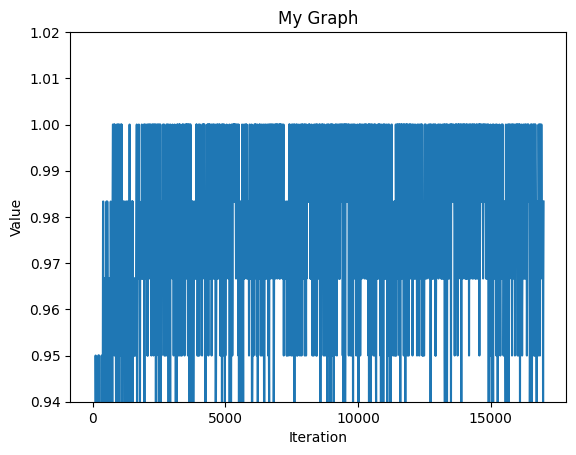

In [24]:
x = list(range(0, len(stats["test_acc"][0])*10, 10))
values = stats["test_acc"][0]

# Create a new figure
plt.figure()

# Plot the values
plt.plot(x, values)

# Add a title and labels to the axes
plt.title('My Graph')
plt.xlabel('Iteration')
plt.ylabel('Value')

# setting the ranges and the ticks
plt.ylim((0.94, 1.02))
plt.xticks(range(0, 18000, 5000))

# Display the graph
plt.show()

# 3 WINNING TICKETS IN CONVOLUTIONAL NEURAL NETWORKS